<a href="https://colab.research.google.com/github/tokarchyn/diabetic-retinopathy-thesis/blob/master/diabetic-retinopathy-ml.ipynb" target="_parent">     
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
import pandas as pd
import os
import sys
from IPython.display import display, clear_output
# %tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
pd.options.mode.chained_assignment = None
AUTOTUNE = tf.data.experimental.AUTOTUNE

Using TensorFlow backend.


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4448523479830787954
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10557643070577399296
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5145085192869484926
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15820685312
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12023265526373507832
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##  Define constants

In [21]:
CLASS_NAMES = np.array(['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR'])
CLASS_INDEXES = range(0,len(CLASS_NAMES))
WIDTH = HEIGHT = 512
BATCH_SIZE = 64
IN_COLAB = 'google.colab' in sys.modules
BASE_IMAGE_DIR = os.path.join('drive/My Drive/Colab Notebooks', 'kaggle_data', 'train') if IN_COLAB else os.path.join('..', 'data', 'train')
TRAIN_LABELS_PATH = os.path.join('drive/My Drive/Colab Notebooks', 'kaggle_data', 'trainLabels.csv') if IN_COLAB else os.path.join(BASE_IMAGE_DIR, '..', 'trainLabels.csv')

## Process dataframe 

In [3]:
def load_df():
  df = pd.read_csv()
  print(df.head())
  return df

def add_features(df):
  df['image_path'] = BASE_IMAGE_DIR + '/' + df['image'].astype(str) + '.jpeg'
  df['level_categorical'] = df['level'].map(lambda x: to_categorical(x, len(CLASS_NAMES), dtype='bool'))
  return df

def remove_unexist(df):
  df['exists'] = df['image_path'].map(os.path.exists)
  df = df[df['exists']].drop(columns=['exists'])
  return df

def train_val_split(df):
  train_img, val_img = train_test_split(df['image'], 
                                        test_size = 0.20, 
                                        random_state = 2020,
                                        stratify = df['level'].to_frame())
  train_df = df[df['image'].isin(train_img)]
  val_df = df[df['image'].isin(val_img)]
  print('train', train_df.shape[0], 'val', val_df.shape[0])
  return train_df, val_df

def balancing(df):
  max_level_count = df['level'].value_counts().max()
  for level in df['level'].unique():
    if level == float('nan'):
      break
    count_of_level = df[df['level']==level].count()[0]
    if count_of_level == max_level_count:
      continue
    to_add = []
    to_add_count = max_level_count - count_of_level
    print('Need to add',to_add_count, 'copies of level', level, 'where count of level is', count_of_level)
    it = iter(df[df['level']==level].iterrows())
    while to_add_count > len(to_add):
      _, row = None, None
      try:
        _, row = next(it)
      except StopIteration:
        it = iter(df[df['level']==level].iterrows())
        _, row = next(it)
      to_add.append(row)
    df = df.append(to_add)
  return df

def shrink_dataset(df, number_of_each_level):
    levels = df['level'].unique()
    df_tmp = df[df['level'] == levels[0]].sample(number_of_each_level)
    for l in levels[1:]:
        df_tmp = df_tmp.append(df[df['level'] == l].sample(number_of_each_level))
    return df_tmp

def prepare_data():
  df = load_df()
  df = add_features(df)
  df = remove_unexist(df)
  df = shrink_dataset(df, 300)
  train_df, val_df = train_val_split(df)
  train_df = balancing(train_df)
  return train_df, val_df

In [4]:
train_df, val_df = prepare_data()

      image  level
0   10_left      0
1  10_right      0
2   13_left      0
3  13_right      0
4   15_left      1
train 1200 val 300


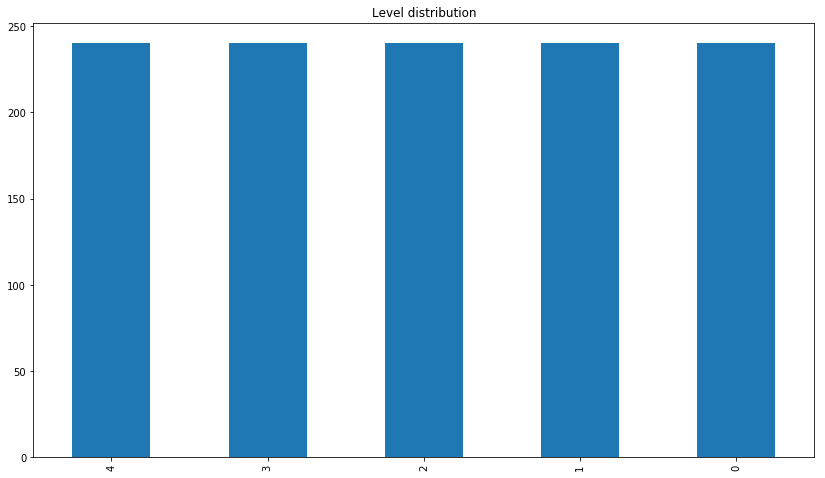

In [110]:
train_df['level'].value_counts().plot(kind='bar', figsize=(14,8), title='Level distribution')

## Build input pipeline

#### Augmentation functions

In [5]:
def rotate(x):
    # Rotate 0, 90, 180, 270 degrees
    return tf.image.rot90(x, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

def flip(x):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    return x

def color(x):
    x = tf.image.random_hue(x, 0.04)
    x = tf.image.random_saturation(x, 0.85, 1.15)
    x = tf.image.random_brightness(x, 0.02)
    x = tf.image.random_contrast(x, 0.85, 1.15)
    return x

def zoom(x):
    # Generate 20 crop settings, ranging from a 1% to 10% crop.
    scales = list(np.arange(0.9, 1.0, 0.01))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]

    def random_crop(img):
        # Create different crops for an image
        crops = tf.image.crop_and_resize([img], boxes=boxes, box_indices=np.zeros(len(scales)), crop_size=(HEIGHT, WIDTH))
        # Return a random crop
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]

    choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)

    # Only apply cropping 50% of the time
    return tf.cond(choice < 0.5, lambda: x, lambda: random_crop(x))

def augment(dataset):
    # Add augmentations
    augmentations = [flip, color, zoom, rotate]

    # Add the augmentations to the dataset
    for f in augmentations:
        # Apply the augmentation, run 4 jobs in parallel.
        dataset = dataset.map(lambda img, level: (f(img),level), num_parallel_calls=4)

    # Make sure that the values are still in [0, 1]
    dataset = dataset.map(lambda img, level: (tf.clip_by_value(img, 0, 1),level), num_parallel_calls=4)
    return dataset

In [6]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [WIDTH, HEIGHT])

def get_label(level):
  # parts = tf.strings.split(file_path, os.path.sep)
  # image_name = tf.strings.split(parts[-1], '.')[0]
  return level == CLASS_INDEXES

def process_path(file_path, level):
  label = get_label(level)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

def prepare_for_validation(ds, cache=True, shuffle_buffer_size=1000):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

def show_batch(image_batch, label_batch):
    fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
    for (c_x, c_y, c_ax) in zip(image_batch, label_batch, m_axs.flatten()):
        c_ax.imshow(c_x)
        c_ax.set_title(CLASS_NAMES[c_y==1][0])
        c_ax.axis('off')     

def dataset_from_tensor_slices(df):
  return tf.data.Dataset.from_tensor_slices((
      df['image_path'].values,
      df['level'].values))

def create_datasets(train_df, val_df):
  train_ds = dataset_from_tensor_slices(train_df)
  val_ds = dataset_from_tensor_slices(val_df)
  train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
  train_ds = augment(train_ds)
  train_ds = prepare_for_training(train_ds, cache='t_c')
  val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
  val_ds = prepare_for_validation(val_ds, cache='v_c')
  return train_ds, len(train_df), val_ds, len(val_df)

In [7]:
train_ds, train_count, val_ds, val_count = create_datasets(train_df, val_df)

In [118]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

KeyboardInterrupt: 

In [15]:
image_batch, label_batch = next(iter(train_ds))

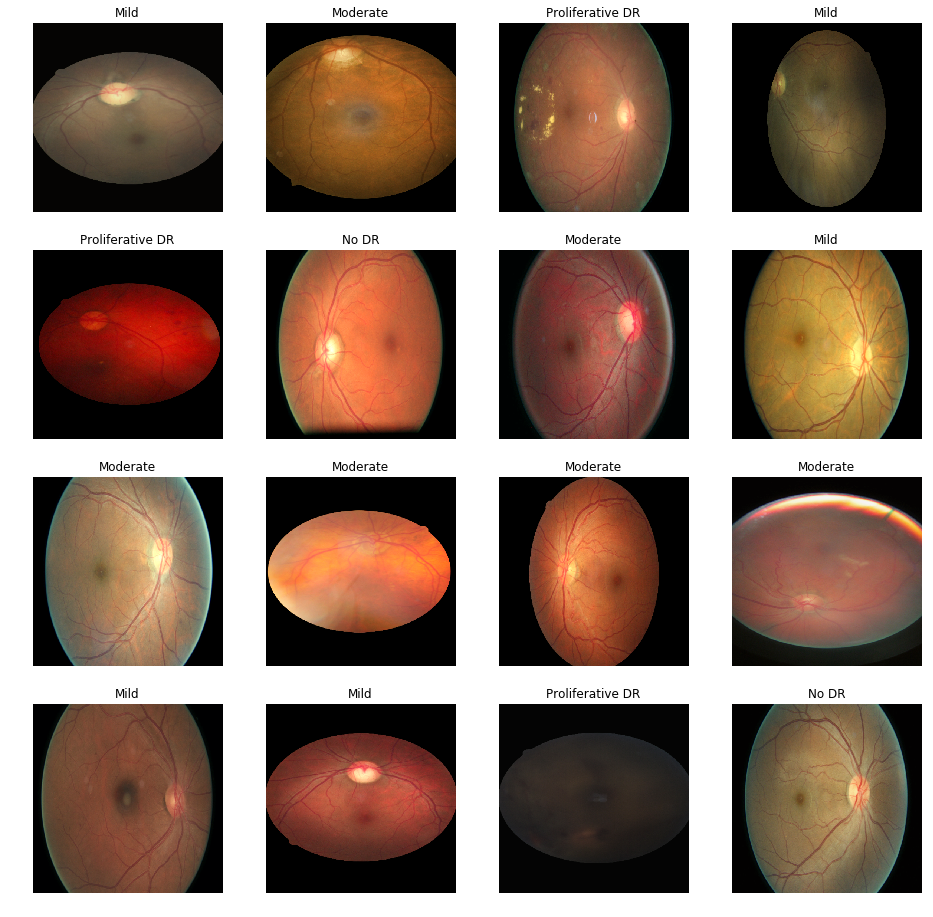

In [16]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [65]:
del model
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.3), padding='valid',input_shape=(HEIGHT, WIDTH, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.3)))
# model.add(layers.Conv2D(32, (3, 3), activation='softmax',padding='same'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='softmax',padding='same'))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='softmax'))
model.add(layers.Dense(len(CLASS_NAMES), activation='softmax'))
model.summary()
model.compile(optimizer='adadelta',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 125, 125, 16)      2320      
_________________________________________________________________
flatten_1 (Flatten)          (None, 250000)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               64000256  
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 1285      
Total params: 64,004,309
Trainable params: 64,004,309
Non-trainable params: 0
__________________________________________

In [11]:
del model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(HEIGHT, WIDTH, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(activation='softmax', units=5))

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=["accuracy"])

In [13]:
model.fit(train_ds, steps_per_epoch=train_count // BATCH_SIZE, epochs=20,
          validation_data=val_ds, validation_steps=val_count // BATCH_SIZE,
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)])

Train for 18 steps, validate for 4 steps
Epoch 1/20
18/18 [==============================] - 18s 1s/step - loss: 3.1276 - accuracy: 0.1806 - val_loss: 1.6095 - val_accuracy: 0.2031
Epoch 2/20
18/18 [==============================] - 15s 820ms/step - loss: 1.6095 - accuracy: 0.2014 - val_loss: 1.6094 - val_accuracy: 0.2031
Epoch 3/20
18/18 [==============================] - 37s 2s/step - loss: 1.6097 - accuracy: 0.1970 - val_loss: 1.6095 - val_accuracy: 0.2031


In [17]:
model.predict_classes(image_batch)

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [ ]:
label_batch

array([[1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1.